In [2]:
pip install imbalanced-learn

     -------------------------------------- 235.6/235.6 kB 4.8 MB/s eta 0:00:00
     -------------------------------------- 302.2/302.2 kB 6.2 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
Note: you may need to restart the kernel to use updated packages.


In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from sklearn.svm import SVC
from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.filterwarnings('ignore')

In [48]:
from sklearn.metrics import roc_auc_score

In [49]:
df = pd.read_csv('loan-train.csv')
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Annual_Income,Loan_Amount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,141.0,360.0,1.0,Urban,Y


In [50]:
df.shape

(614, 12)

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Loan_ID           614 non-null    object 
 1   Gender            601 non-null    object 
 2   Married           611 non-null    object 
 3   Dependents        599 non-null    object 
 4   Education         614 non-null    object 
 5   Self_Employed     582 non-null    object 
 6   Annual_Income     614 non-null    int64  
 7   Loan_Amount       592 non-null    float64
 8   Loan_Amount_Term  600 non-null    float64
 9   Credit_History    564 non-null    float64
 10  Property_Area     614 non-null    object 
 11  Loan_Status       614 non-null    object 
dtypes: float64(3), int64(1), object(8)
memory usage: 57.7+ KB


In [52]:
df.describe()

,Annual_Income,Loan_Amount,Loan_Amount_Term,Credit_History
count,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,146.412162,342.00000,0.842199
std,6109.041673,85.587325,65.12041,0.364878
min,150.000000,9.000000,12.00000,0.000000
25%,2877.500000,100.000000,360.00000,1.000000
50%,3812.500000,128.000000,360.00000,1.000000
75%,5795.000000,168.000000,360.00000,1.000000
max,81000.000000,700.000000,480.00000,1.000000


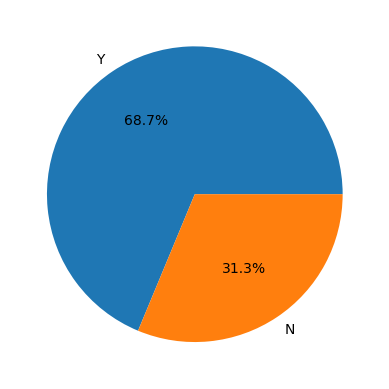

In [55]:
temp = df['Loan_Status'].value_counts()
plt.pie(temp.values,
		labels=temp.index,
		autopct='%1.1f%%')
plt.show()

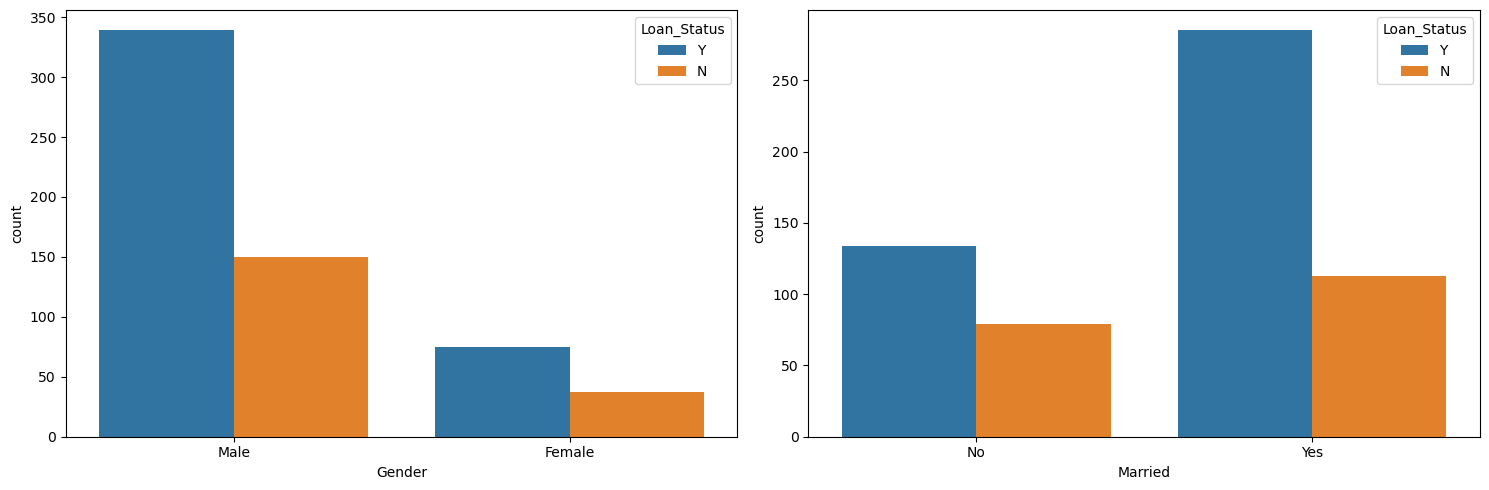

In [56]:
plt.subplots(figsize=(15, 5))
for i, col in enumerate(['Gender', 'Married']):
	plt.subplot(1, 2, i+1)
	sb.countplot(df[col], hue=df['Loan_Status'])
plt.tight_layout()
plt.show()

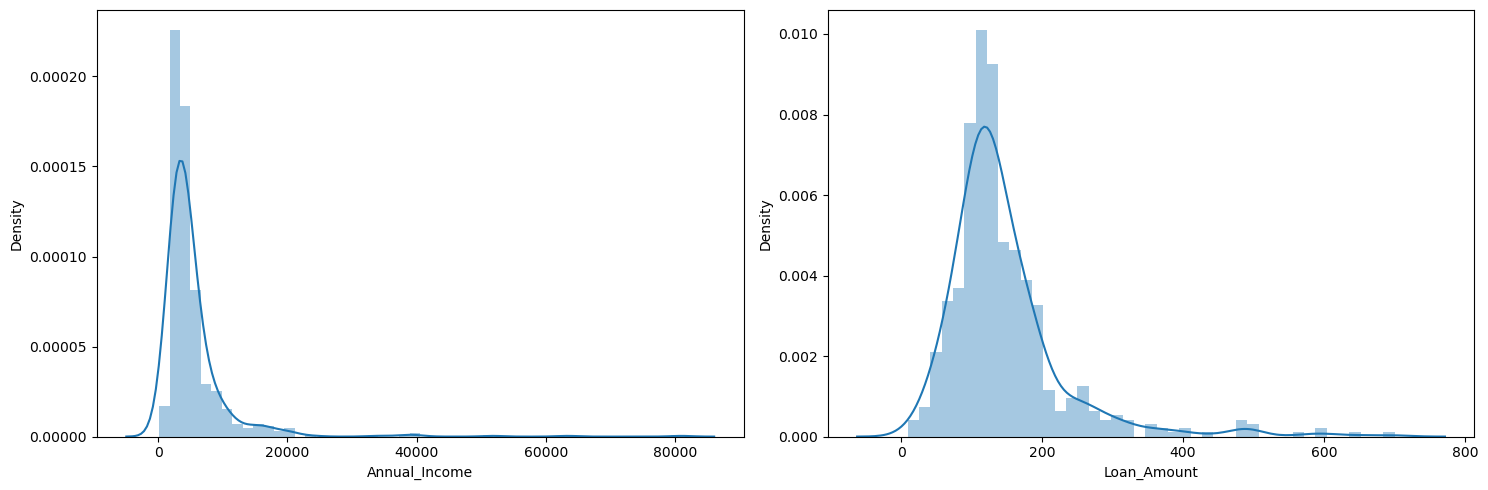

In [57]:
plt.subplots(figsize=(15, 5))
for i, col in enumerate(['Annual_Income', 'Loan_Amount']):
	plt.subplot(1, 2, i+1)
	sb.distplot(df[col])
plt.tight_layout()
plt.show()

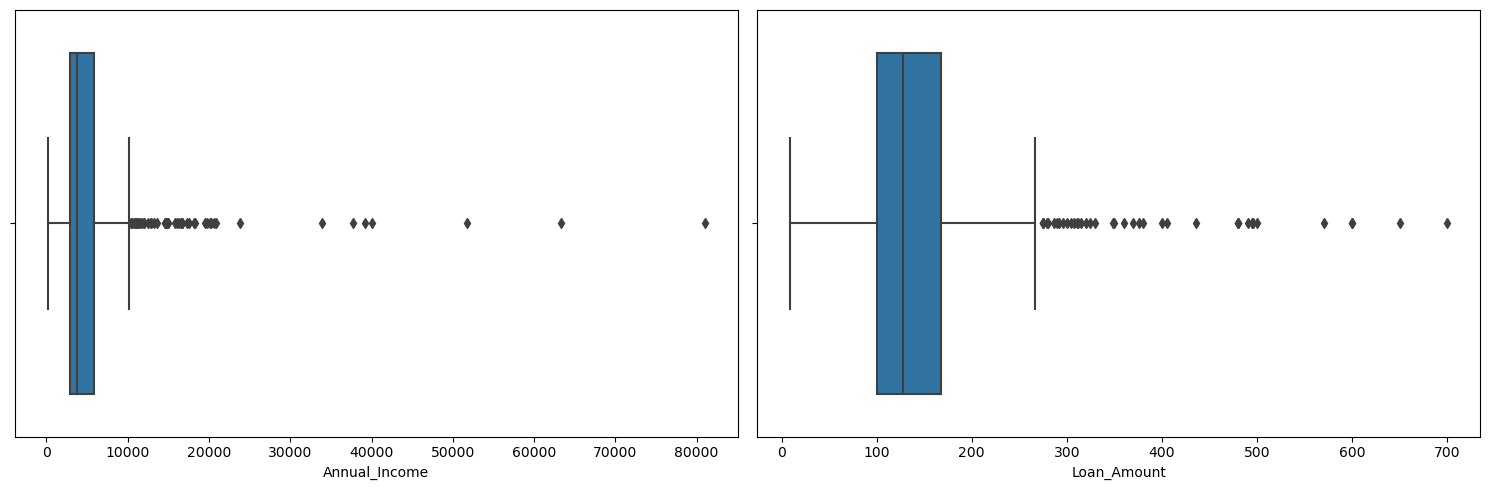

In [58]:
plt.subplots(figsize=(15, 5))
for i, col in enumerate(['Annual_Income', 'Loan_Amount']):
	plt.subplot(1, 2, i+1)
	sb.boxplot(df[col])
plt.tight_layout()
plt.show()

In [59]:
df = df[df['Annual_Income'] < 25000]
df = df[df['Loan_Amount'] < 400000]

In [60]:
df.groupby('Gender').mean()['Loan_Amount']

Gender
Female    126.697248
Male      146.924569
Name: Loan_Amount, dtype: float64

In [61]:
df.groupby(['Married', 'Gender']).mean()['Loan_Amount']

Married  Gender
No       Female    116.115385
         Male      135.959677
Yes      Female    153.322581
         Male      150.875740
Name: Loan_Amount, dtype: float64

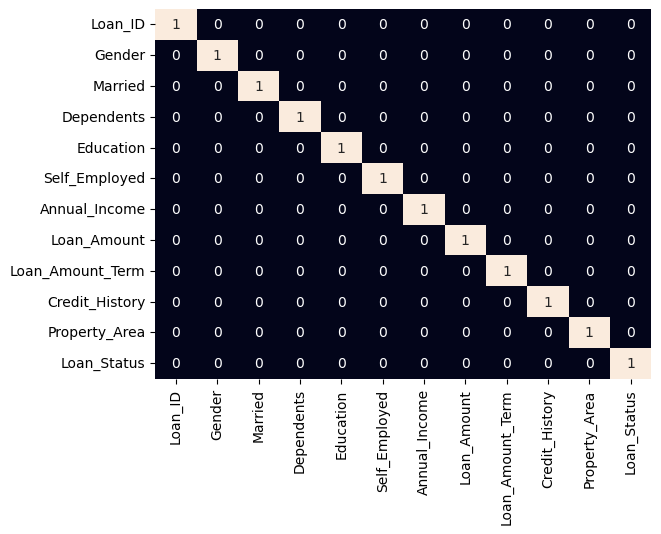

In [62]:
# Function to apply label encoding
def encode_labels(data):
	for col in data.columns:
		if data[col].dtype == 'object':
			le = LabelEncoder()
			data[col] = le.fit_transform(data[col])

	return data

# Applying function in whole column
df = encode_labels(df)

# Generating Heatmap
sb.heatmap(df.corr() > 0.8, annot=True, cbar=False)
plt.show()

In [63]:
features = df.drop('Loan_Status', axis=1)
target = df['Loan_Status'].values

X_train, X_val,\
Y_train, Y_val = train_test_split(features, target,
    test_size=0.2,
    random_state=10)

# As the data was highly imbalanced we will balance
# it by adding repetitive rows of minority class.
ros = RandomOverSampler(sampling_strategy='minority',
						random_state=0)
X, Y = ros.fit_resample(X_train, Y_train)

X_train.shape, X.shape

((468, 11), (666, 11))

In [64]:
# Normalizing the features for stable and fast training.
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_val = scaler.transform(X_val)

In [72]:
X_cleaned = np.nan_to_num(X)  # Replace NaN and Inf with zeros
Y_cleaned = np.nan_to_num(Y)

In [76]:
X_val_cleaned = np.nan_to_num(X_val)

In [77]:
predictions_val = model.predict(X_val_cleaned)

In [78]:
from sklearn.metrics import roc_auc_score
model = SVC(kernel='rbf')
model.fit(X_cleaned, Y_cleaned)

print('Training ROC AUC Score:', roc_auc_score(Y_cleaned, model.predict(X_cleaned)))
print('Validation ROC AUC Score:', roc_auc_score(Y_val, predictions_val))

Training ROC AUC Score: 0.8768768768768769
Validation ROC AUC Score: 0.6086550435865504


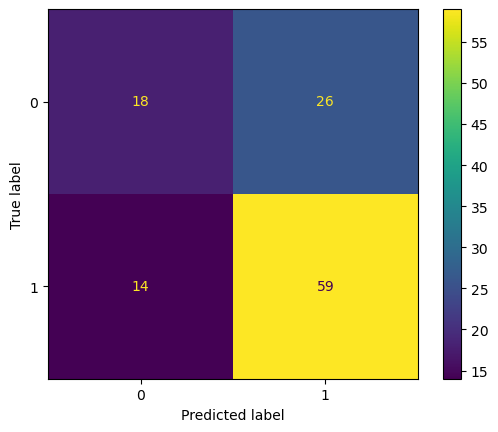

In [80]:
metrics.plot_confusion_matrix(model, X_val_cleaned, Y_val)
plt.show()

In [82]:
from sklearn.metrics import classification_report
print(classification_report(Y_val, model.predict(X_val_cleaned)))

              precision    recall  f1-score   support

           0       0.56      0.41      0.47        44
           1       0.69      0.81      0.75        73

    accuracy                           0.66       117
   macro avg       0.63      0.61      0.61       117
weighted avg       0.64      0.66      0.64       117

